### Transfer Learning with MobileNetV2
- Preprocess and augment data using the Sequential API
- Adapt a pretrained model to new data and train a classifier using the Functional API and MobileNet
- Fine-tune a classifier's final layers to improve accuracy 

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [16]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=0.2, subset='training', seed=42)
validation_dataset = image_dataset_from_directory(directory, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=0.2, subset='validation', seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


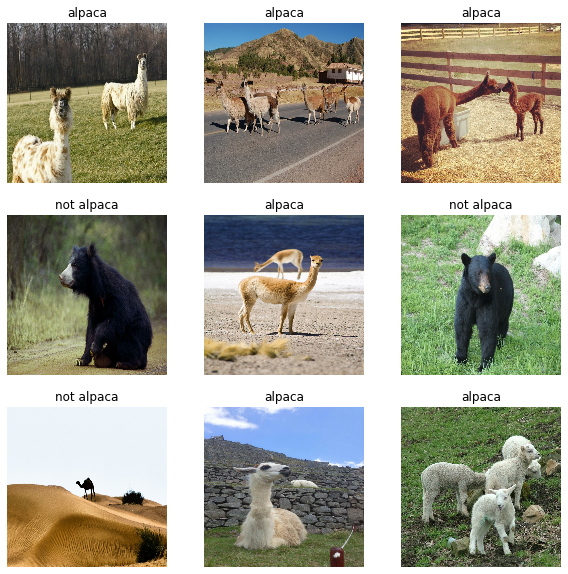

In [17]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### Preprocess and Augment Training Data

In [18]:
# Autotune prompts tf.data to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [19]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    return data_augmentation

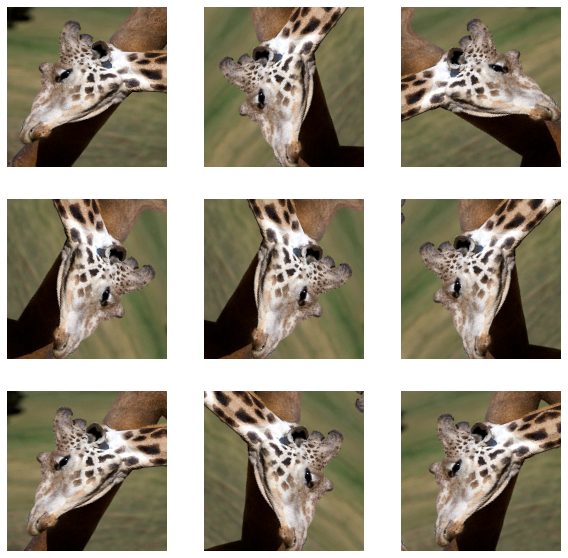

In [20]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [21]:
# normalize input (pretrained normalization values MobileNetV2 was trained on)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#### Using MobileNetV2 for Transfer Learning

In [22]:
# load the pretrained weights from ImageNet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=True, weights='imagenet')

In [23]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [24]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [25]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0])>

In [26]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04589890', 'window_screen', 0.42582327),
  ('n02708093', 'analog_clock', 0.09275591)],
 [('n04589890', 'window_screen', 0.23985903),
  ('n03887697', 'paper_towel', 0.14802667)],
 [('n04589890', 'window_screen', 0.7449468),
  ('n03598930', 'jigsaw_puzzle', 0.02194887)],
 [('n04589890', 'window_screen', 0.33545947),
  ('n03530642', 'honeycomb', 0.07628966)],
 [('n04589890', 'window_screen', 0.2732732),
  ('n03733281', 'maze', 0.08847063)],
 [('n04589890', 'window_screen', 0.6745263),
  ('n03530642', 'honeycomb', 0.07659912)],
 [('n04589890', 'window_screen', 0.7912859),
  ('n04209239', 'shower_curtain', 0.0924162)],
 [('n04589890', 'window_screen', 0.16463025),
  ('n03598930', 'jigsaw_puzzle', 0.08749203)],
 [('n03598930', 'jigsaw_puzzle', 0.37021214),
  ('n04589890', 'window_screen', 0.09957095)],
 [('n04589890', 'window_screen', 0.6161678),
  ('n03887697', 'paper_towel', 0.054876685)],
 [('n03530642', 'honeycomb', 0.2544885),
  ('n04589890', 'window_screen', 0.24874578)],
 [('n045

Wrong labels, This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when you use the full model, all you get is a bunch of incorrectly classified images.

can delete the top layer, which contains all the classification labels, and create a new classification layer.

#### Layer Freezing with the Functional API

using a pretrained model to modify the classifier task so that it's able to recognize alpacas. 
achieve this in three steps: 

1. Delete the top layer (the classification layer)
2. Add a new classifier layer
3. Freeze the base model and train the newly-created classifier layer

In [27]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation = data_augmenter()):
    input_shape = image_shape + (3,)
      
    base_model = tf.keras.applications.MobileNetV2(input_shape = input_shape, include_top = False, weights = 'imagenet')
    
    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape = input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(1)(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [28]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [29]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

C:\Users\archi\AppData\Roaming\Python\Python37\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [31]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 4s 162ms/step - loss: 0.8075 - accuracy: 0.5115 - val_loss: 0.6573 - val_accuracy: 0.5385
Epoch 2/5
9/9 [==============================] - 1s 36ms/step - loss: 0.6879 - accuracy: 0.5878 - val_loss: 0.5456 - val_accuracy: 0.6923
Epoch 3/5
9/9 [==============================] - 1s 39ms/step - loss: 0.5626 - accuracy: 0.6908 - val_loss: 0.4400 - val_accuracy: 0.7846
Epoch 4/5
9/9 [==============================] - 1s 37ms/step - loss: 0.4512 - accuracy: 0.7748 - val_loss: 0.4250 - val_accuracy: 0.7538
Epoch 5/5
9/9 [==============================] - 1s 34ms/step - loss: 0.4352 - accuracy: 0.7557 - val_loss: 0.3608 - val_accuracy: 0.8154


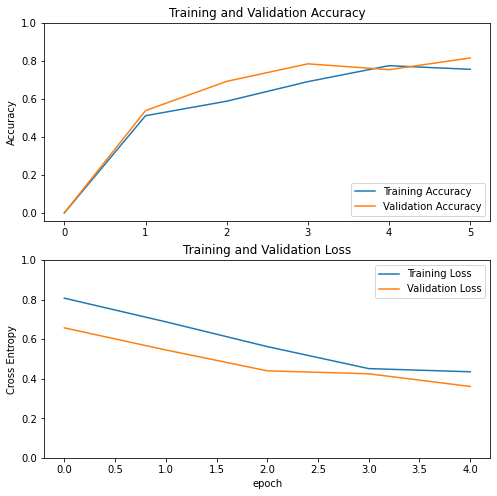

In [32]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
class_names

['alpaca', 'not alpaca']

#### Fine-tuning the Model
By unfreezing the final layers and re-running the optimizer with a smaller learning rate, while keeping all the other layers frozen to improve accuracy

In [ ]:
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = True
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits = True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(lr = 0.1 * base_learning_rate)

# Use accuracy as evaluation metric
metrics = ['accuracy']

model2.compile(loss=loss_function, optimizer = optimizer, metrics=metrics)

In [34]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 1s 35ms/step - loss: 0.4018 - accuracy: 0.8053 - val_loss: 0.3272 - val_accuracy: 0.8462
Epoch 6/10
9/9 [==============================] - 1s 34ms/step - loss: 0.3491 - accuracy: 0.8168 - val_loss: 0.3098 - val_accuracy: 0.8769
Epoch 7/10
9/9 [==============================] - 1s 35ms/step - loss: 0.3505 - accuracy: 0.8321 - val_loss: 0.2776 - val_accuracy: 0.8769
Epoch 8/10
9/9 [==============================] - 1s 36ms/step - loss: 0.3203 - accuracy: 0.8473 - val_loss: 0.2666 - val_accuracy: 0.8769
Epoch 9/10
9/9 [==============================] - 1s 35ms/step - loss: 0.3297 - accuracy: 0.8206 - val_loss: 0.2420 - val_accuracy: 0.9385
Epoch 10/10
9/9 [==============================] - 1s 33ms/step - loss: 0.3138 - accuracy: 0.8359 - val_loss: 0.2260 - val_accuracy: 0.9385


In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

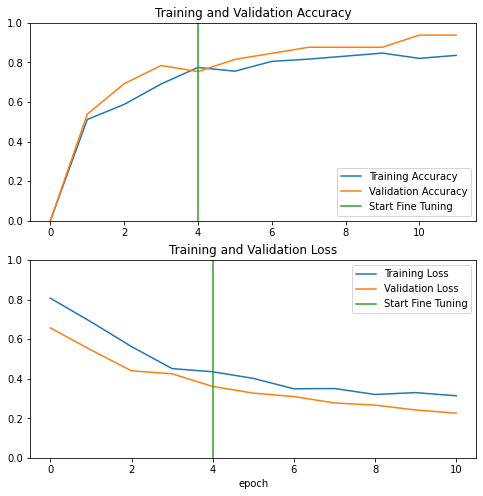

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()